In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeRegressor

import copy
import json
from collections import Counter
import torch

from sklearn.metrics import r2_score, roc_auc_score, precision_score, accuracy_score, recall_score, classification_report, mean_absolute_percentage_error
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score, adjusted_rand_score, fowlkes_mallows_score, adjusted_mutual_info_score

#Читска данных

In [ ]:
data_from_hh = pd.read_csv('/content/drive/MyDrive/Вакансии/data_all.csv')

In [ ]:
data_from_hh

id                                               json  \
0      69395089  {"id": "69395089", "premium": false, "billing_...   
1      72044588  {"id": "72044588", "premium": false, "billing_...   
2      71718619  {"id": "71718619", "premium": false, "billing_...   
3      72152388  {"id": "72152388", "premium": false, "billing_...   
4      71998299  {"id": "71998299", "premium": false, "billing_...   
...         ...                                                ...   
10941  71949646  {"id": "71949646", "premium": false, "billing_...   
10942  71655968  {"id": "71655968", "premium": false, "billing_...   
10943  71785276  {"id": "71785276", "premium": false, "billing_...   
10944  71512755  {"id": "71512755", "premium": false, "billing_...   
10945  71705283  {"id": "71705283", "premium": false, "billing_...   

                                               prep_desc  
0      ["responsibilities", "creatives", "production"...  
1      ["филиал", "cerаmo", "stone", "group", "г.атыр...  
2      ["разработчик", "react", "native", "проект", "...  
3      ["обязанность", "хозяйственный", "часть", "бух...  
4      ["обязанность", "видеосъёмка", "монтаж", "треб...  
...                                                  ...  
10941  ["туристический", "компания", "требоваться", "...  
10942  ["«", "деньга", "маркет", "»", "являться", "ли...  
10943  ["искать", "активный", "ответственный", "консу...  
10944  ["обязанность", "проектирование", "мебель", "з...  
10945  ["обязанность", "активно", "участвовать", "про...  

[10946 rows x 3 columns]

In [ ]:
prep_desc = data_from_hh['prep_desc']

In [ ]:
for i in range(len(prep_desc)):
  data_from_hh['prep_desc'][i] = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])|([_])|([,]{2,}?)", "", data_from_hh['prep_desc'][i])
for i in range(len(prep_desc)):
  data_from_hh['prep_desc'][i] = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])|([_])|([,]{2,}?)", "", data_from_hh['prep_desc'][i])

<ipython-input-6-718f8f386f64>:2: FutureWarning: Possible nested set at position 2
  data_from_hh['prep_desc'][i] = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])|([_])|([,]{2,}?)", "", data_from_hh['prep_desc'][i])
<ipython-input-6-718f8f386f64>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_from_hh['prep_desc'][i] = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])|([_])|([,]{2,}?)", "", data_from_hh['prep_desc'][i])
<ipython-input-6-718f8f386f64>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_from_hh['prep_desc'][i] = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])|([_])|([,]{2,}?)", "", data_from_hh['prep_desc'][i])


In [ ]:
for i in range(len(prep_desc)):
  data_from_hh['prep_desc'][i] = re.sub(r"«", "", data_from_hh['prep_desc'][i])
  data_from_hh['prep_desc'][i] = re.sub(r"»", "", data_from_hh['prep_desc'][i])

<ipython-input-7-e903e1fef24b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_from_hh['prep_desc'][i] = re.sub(r"«", "", data_from_hh['prep_desc'][i])
<ipython-input-7-e903e1fef24b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_from_hh['prep_desc'][i] = re.sub(r"»", "", data_from_hh['prep_desc'][i])


In [ ]:
data_from_hh.shape

(10946, 3)

#Метрики

In [ ]:
metrics = ({'type vectorizer' : [], 'type task': [], 'model' : [], 'test_accuracy' : [], 'test_recall' :[] , 'test_precision' :[], 'test_r2' : [], 'test_MAPE' : []}) #заводим пустой датафрейм для хранения показателей метрик качества
df_metrics = pd.DataFrame(metrics)

In [ ]:
def metrics_of_quality(type_vectorizer, type_task, df, model, y_test, y_pred):  # функция для оценки качества обученной модели
  if type_task == "Classification":
    test_ac = accuracy_score(y_test, y_pred).round(4)
    test_rec = recall_score(y_test, y_pred, average = 'macro').round(4)
    test_prec = precision_score(y_test, y_pred, average = 'macro').round(4)
    new_row = {'type vectorizer' : type_vectorizer, 'type task': type_task, 'model' : model, 'test_accuracy' : test_ac, 'test_recall' : test_rec, 
               'test_precision' : test_prec, 'test_r2' : "-", 'test_MAPE' : "-"}
  elif type_task == "Regression":
    test_r2 = r2_score(y_test, y_pred) #Коэффициент детерминации
    test_MAPE = mean_absolute_percentage_error(y_test, y_pred) #Средняя абсолютная процентная ошибка(показывает долю неправильных ответов)
    new_row = {'type vectorizer' : type_vectorizer, 'type task': type_task, 'model' : model, 'test_accuracy' : "-", 'test_recall' : "-", 
               'test_precision' : "-", 'test_r2' : test_r2, 'test_MAPE' : test_MAPE}
  df = df.append(new_row, ignore_index = True)
  return df

#Предобработка

In [ ]:
info_prof = dict()        
prepared_json = list()    

for json_str in data_from_hh['json']:
  this_json = json.loads(json_str)

  prepared_json.append(this_json)


  id_prof = this_json['professional_roles'][0]['id']
  if id_prof not in info_prof:
    info_prof[id_prof] = {'name': this_json['professional_roles'][0]['name'], 'sum_salary_from': 0, 'sum_salary_to': 0, 'n': 0}

In [ ]:
for key, value in info_prof.items():
  name = value['name']
  print(f'ID профессии - {key}, название - {name}')

print(f'Всего уникальных профессий - {len(set(info_prof))}')

ID профессии - 68, название - Менеджер по маркетингу, интернет-маркетолог
ID профессии - 70, название - Менеджер по продажам, менеджер по работе с клиентами
ID профессии - 96, название - Программист, разработчик
ID профессии - 18, название - Бухгалтер
ID профессии - 20, название - Видеооператор, видеомонтажер
ID профессии - 62, название - Мастер-приемщик
ID профессии - 102, название - Разнорабочий
ID профессии - 89, название - Официант, бармен, бариста
ID профессии - 131, название - Упаковщик, комплектовщик
ID профессии - 69, название - Менеджер по персоналу
ID профессии - 144, название - Инженер-энергетик, инженер-электрик
ID профессии - 21, название - Водитель
ID профессии - 72, название - Менеджер по туризму
ID профессии - 113, название - Системный администратор
ID профессии - 16, название - Аудитор
ID профессии - 94, название - Повар, пекарь, кондитер
ID профессии - 83, название - Оператор call-центра, специалист контактного центра
ID профессии - 99, название - Промоутер
ID професс

In [ ]:
i = 0
for JSON in prepared_json:
  this_salary = JSON['salary']
  id_prof = JSON['professional_roles'][0]['id']

  if this_salary != None and this_salary['from'] != None and this_salary['to'] != None:
    info_prof[id_prof]['sum_salary_from'] += this_salary['from']
    info_prof[id_prof]['sum_salary_to'] += this_salary['to']
    info_prof[id_prof]['n'] += 1

In [ ]:
max_zp = -1
min_zp = 100000

for key, value in info_prof.items():
  name = value['name']

  if value['n']:
    zp = (value['sum_salary_from'] + value['sum_salary_to']) // (2 * value['n'])
    max_zp = max(max_zp, zp)
    min_zp = min(min_zp, zp)
    print(f'ID профессии - {key}, название - {name} --->> Средняя зп - {zp}')

print(max_zp, min_zp, end='\n-----------------------------------------------\n')

print("Профессии, для которых не вычесленны средние зп:")

for key, value in info_prof.items():
  name = value['name']

  if not value['n']:
    print(f'ID профессии - {key}, название - {name}')

ID профессии - 68, название - Менеджер по маркетингу, интернет-маркетолог --->> Средняя зп - 844297
ID профессии - 70, название - Менеджер по продажам, менеджер по работе с клиентами --->> Средняя зп - 814214
ID профессии - 96, название - Программист, разработчик --->> Средняя зп - 729789
ID профессии - 18, название - Бухгалтер --->> Средняя зп - 806298
ID профессии - 20, название - Видеооператор, видеомонтажер --->> Средняя зп - 165900
ID профессии - 62, название - Мастер-приемщик --->> Средняя зп - 668813
ID профессии - 102, название - Разнорабочий --->> Средняя зп - 101750
ID профессии - 89, название - Официант, бармен, бариста --->> Средняя зп - 253801
ID профессии - 131, название - Упаковщик, комплектовщик --->> Средняя зп - 68455
ID профессии - 69, название - Менеджер по персоналу --->> Средняя зп - 1620918
ID профессии - 144, название - Инженер-энергетик, инженер-электрик --->> Средняя зп - 1396818
ID профессии - 21, название - Водитель --->> Средняя зп - 301172
ID профессии - 7

In [ ]:
clasf_name_professional = list()    #  Названия профессия для классификации
reg_middle_salary = list()          # Средняя зп для регрессии

middle_salary_RF = 56782   # Средняя зп по России

for JSON in prepared_json:
  clasf_name_professional.append(JSON['professional_roles'][0]['name'])

  this_salary = JSON['salary']
  id = JSON['professional_roles'][0]['id']
  if not this_salary or not info_prof[id]['n']:
    # Берем среднюю по профессии, если такая существует, иначе как срендюю по России
    if info_prof[id]['n']:
      zp = (info_prof[id]['sum_salary_from'] + info_prof[id]['sum_salary_to']) // (2 * info_prof[id]['n'])
    else:
      zp = middle_salary_RF
    reg_middle_salary.append(zp)

  else:
    salary_from = this_salary['from'] // 2 if this_salary['from'] else info_prof[id]['sum_salary_from'] // (2 * info_prof[id]['n'])
    salary_to = this_salary['to'] // 2 if this_salary['to'] else info_prof[id]['sum_salary_to'] // (2 * info_prof[id]['n'])

    reg_middle_salary.append(salary_from + salary_to)

In [ ]:
def comparison_table(middle_salary):
  MROT = 15279 

  comparsion = {
      f'Меньше {MROT}': 0,
      f'От {MROT} до 20к': 0,
      'От 20к до 30к': 0,
      'От 30к до 40к': 0,
      'От 40к до 50к': 0,
      'От 50к до 60к': 0,
      'От 60к до 70к': 0,
      'От 70к до 80к': 0,
      'От 80к до 90к': 0,
      'От 90к до 100к': 0,
      'От 100к до 200к': 0,
      'От 200к до 300к': 0,
      'Более 300к': 0
  }

  for salary in middle_salary:

    if salary < MROT:
      comparsion[f'Меньше {MROT}'] += 1
    elif salary < 20000:
      comparsion[f'От {MROT} до 20к'] += 1
    elif salary >= 100000:
      number = salary // 100000
      if salary >= 300000:
        comparsion['Более 300к'] += 1
      else:
        comparsion[f'От {number}00к до {number + 1}00к'] += 1
    else:
      number = salary // 10000
      comparsion[f'От {number}0к до {number + 1}0к'] += 1
    
  fig = plt.figure(figsize = (25, 5))

  plt.bar(comparsion.keys(), comparsion.values(), color ='green',
          width = 0.4)
  
  plt.xlabel("Интервалы")
  plt.ylabel("Количество")
  plt.title("Средние зарплаты вакансий")

  plt.show()

In [ ]:
clasf_name_professional

['Менеджер по маркетингу, интернет-маркетолог',
 'Менеджер по продажам, менеджер по работе с клиентами',
 'Программист, разработчик',
 'Бухгалтер',
 'Видеооператор, видеомонтажер',
 'Мастер-приемщик',
 'Разнорабочий',
 'Официант, бармен, бариста',
 'Упаковщик, комплектовщик',
 'Менеджер по персоналу',
 'Инженер-энергетик, инженер-электрик',
 'Водитель',
 'Официант, бармен, бариста',
 'Менеджер по туризму',
 'Системный администратор',
 'Аудитор',
 'Повар, пекарь, кондитер',
 'Оператор call-центра, специалист контактного центра',
 'Промоутер',
 'Бухгалтер',
 'Кладовщик',
 'Инженер-конструктор, инженер-проектировщик',
 'Сварщик',
 'Менеджер по работе с партнерами',
 'Менеджер ресторана',
 'Официант, бармен, бариста',
 'Менеджер по логистике, менеджер по ВЭД',
 'Другое',
 'Учитель, преподаватель, педагог',
 'Кладовщик',
 'Водитель',
 'Кредитный специалист',
 'Начальник смены, мастер участка',
 'Специалист по кадрам',
 'Менеджер по продажам, менеджер по работе с клиентами',
 'Другое',
 'Дру

In [ ]:
prepared_desc = copy.deepcopy(data_from_hh['prep_desc'])  

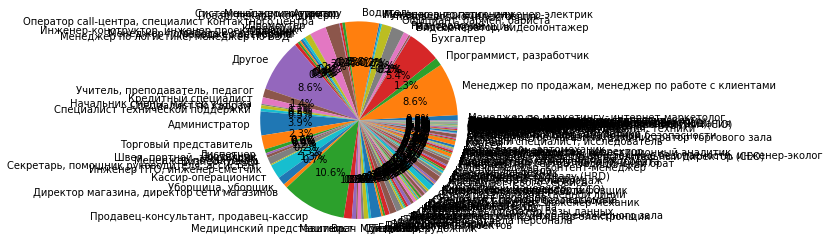

In [ ]:
name = list()
n = list()

for prof in info_prof.values():
  name.append(prof['name'])
  n.append(prof['n'])

fig1, ax1 = plt.subplots()
ax1.pie(n, labels=name, autopct='%1.1f%%')
ax1.axis('equal')  

# plt.legend(name, loc="best")

plt.show()

#Классификация


In [ ]:
model_output = torch.load(f'/content/drive/MyDrive/Embedings/all_embedings.pt')

In [ ]:
len(model_output)

10946

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(model_output, clasf_name_professional[0:len(model_output)], test_size = 0.3)

In [ ]:
del model_output

In [ ]:
X_train = torch.Tensor.detach(X_train)
X_train = X_train.reshape(len(X_train), -1)
X_test = torch.Tensor.detach(X_test)
X_test = X_test.reshape(len(X_test), -1)

In [ ]:
clf_SVM = svm.SVC() #обучение по методу опорных векторов
clf_SVM.fit(X_train, y_train)

SVC()

In [ ]:
y_pred_SVM = clf_SVM.predict(X_test)

In [ ]:
metrics_of_quality('-', 'Classification', df_metrics, "SVM", y_test, y_pred_SVM)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


type vectorizer       type task model  test_accuracy  test_recall  \
0               -  Classification   SVM         0.3931       0.1036   

   test_precision test_r2 test_MAPE  
0          0.2078       -         -

In [ ]:
del y_pred_SVM
del clf_SVM

#Регрессия

In [ ]:
model_output = torch.load(f'/content/drive/MyDrive/Embedings/all_embedings.pt')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(model_output, reg_middle_salary[0:len(model_output)], test_size = 0.3)
del model_output

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train = torch.Tensor.detach(X_train)
X_train = X_train.reshape(len(X_train), -1)
X_test = torch.Tensor.detach(X_test)
X_test = X_test.reshape(len(X_test), -1)

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

In [ ]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [ ]:
y_pred_tree = regr.predict(X_test)

In [ ]:
metrics_of_quality('-', 'Regression', df_metrics, "DTR", y_test, y_pred_tree)

type vectorizer   type task model test_accuracy test_recall test_precision  \
0               -  Regression   DTR             -           -              -   

    test_r2  test_MAPE  
0 -0.055893  40.643352